In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
import yfinance as yf

In [2]:
start = '2010-01-01'
end = '2019-12-01'

In [3]:
df = yf.download('AAPL',start,end)
df = df.reset_index()

[*********************100%***********************]  1 of 1 completed


In [4]:
ma100 = df.Close.rolling(100).mean()
ma200 = df.Close.rolling(200).mean()

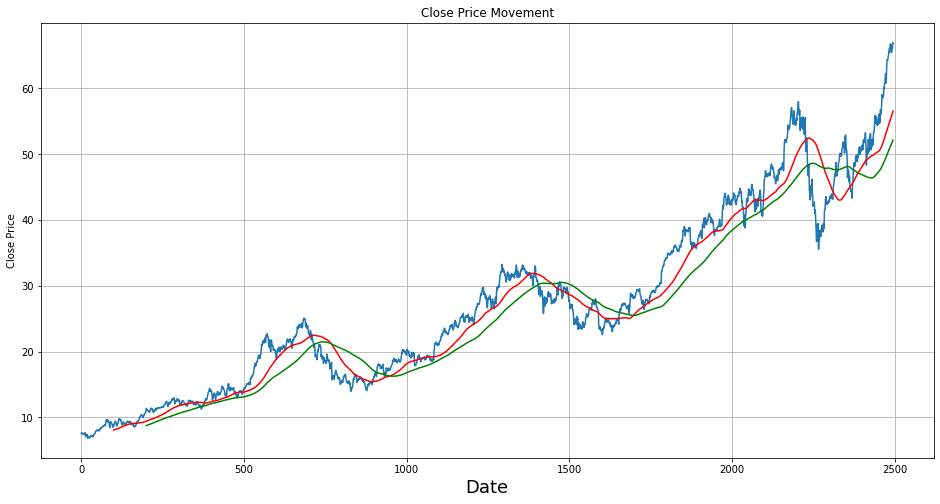

In [5]:
plt.figure(figsize=(16,8))
plt.title("Close Price Movement")
plt.plot(df['Close'])
plt.plot(ma100, 'r')
plt.plot(ma200, 'g')
plt.xlabel("Date",fontsize=18)
plt.grid()
plt.ylabel("Close Price")
plt.show()


In [6]:
train_dates = pd.to_datetime(df['Date'])

In [7]:
cols = list(df)[1:6]

In [8]:
df_for_training = df[cols[0]].astype(float)
df_for_training = pd.DataFrame(df_for_training)

In [9]:
sc = MinMaxScaler(feature_range = (0, 1))
df_for_training_scaled = sc.fit_transform(df_for_training)
df_for_training_scaled

array([[0.01233563],
       [0.01251389],
       [0.01320911],
       ...,
       [0.996007  ],
       [0.99035013],
       [0.99459281]])

In [10]:
trainX = []
trainY = []


n_future = 1   # Number of days we want to predict into the future
n_past = 60     # Number of past days we want to use to predict the future



for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

In [11]:
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (2436, 60, 1).
trainY shape == (2436, 1).


In [12]:
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))


In [13]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 128)           66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 64)            49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 128,417
Trainable params: 128,417
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(trainX, trainY, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/20
69/69 [==============================] - 26s 83ms/step - loss: 0.0536 - val_loss: 0.0047
Epoch 2/20
69/69 [==============================] - 5s 67ms/step - loss: 0.0057 - val_loss: 0.0020
Epoch 3/20
69/69 [==============================] - 5s 75ms/step - loss: 0.0044 - val_loss: 0.0024
Epoch 4/20
69/69 [==============================] - 6s 93ms/step - loss: 0.0041 - val_loss: 0.0035
Epoch 5/20
69/69 [==============================] - 6s 87ms/step - loss: 0.0037 - val_loss: 0.0025
Epoch 6/20
69/69 [==============================] - 6s 87ms/step - loss: 0.0029 - val_loss: 0.0117
Epoch 7/20
69/69 [==============================] - 6s 87ms/step - loss: 0.0032 - val_loss: 0.0027
Epoch 8/20
69/69 [==============================] - 6s 85ms/step - loss: 0.0025 - val_loss: 0.0041
Epoch 9/20
69/69 [==============================] - 7s 95ms/step - loss: 0.0025 - val_loss: 0.0038
Epoch 10/20
69/69 [==============================] - 7s 101ms/step - loss: 0.0028 - val_loss: 0.0042
Epoch 1

In [15]:
model.save('final_model.h5')

In [16]:
n_future=60  


forecast_period_dates = pd.date_range(list(train_dates)[-40], periods=n_future, freq='1d').tolist()

forecast = model.predict(trainX[-n_future:])

In [17]:
forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future = sc.inverse_transform(forecast_copies)[:,0]


In [18]:
# Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
    

In [19]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

In [20]:
original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2010-11-29']

<ipython-input-20-b8fb2cdc04c3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


/home/shantaram/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/shantaram/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Date', ylabel='Open'>

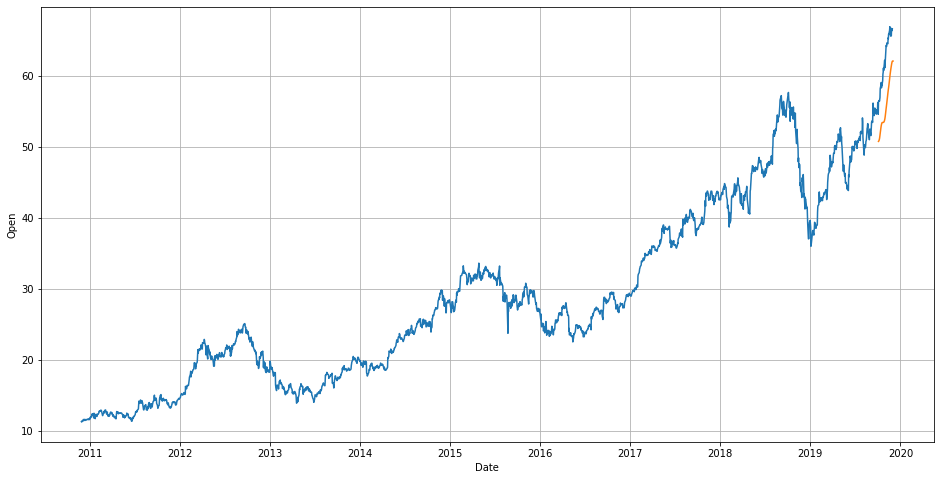

In [21]:
plt.figure(figsize=(16,8))

plt.grid()

sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])